# LSTM code with Hyperparameter tuning via Optuna

In [ ]:
!pip install optuna # tensorflow version : 2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/project')
!ls

Data				 Plots	  Sentiment_Analysis.ipynb
Model_Prediction_Pipeline.ipynb  Results  Sentiment.ipynb
Models				 Scalers  Stacked_LSTM_code.ipynb


In [6]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import os
import joblib
import json
import optuna
import matplotlib
matplotlib.use('Agg')  # switch to non-interactive backend
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

ModuleNotFoundError: No module named 'optuna'

In [ ]:
# Code for Hyperparameter Tuning  pipeline via Optuna
class Tuning:
    def __init__(self, ticker: str = None, period: str = '5y'):
        self.ticker = ticker
        self.period = period
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.dataset = None
        self.train_features, self.val_features, self.test_features = None, None, None
        self.train_target, self.val_target, self.test_target = None, None, None

    def fetch_data(self) -> pd.DataFrame:
        print(f'Fetching Data of {self.ticker} for {self.period}.....')
        self.dataset = yf.Ticker(self.ticker).history(period=self.period)
        if self.dataset.empty:
            print(f'No Data found for {self.ticker}')
        else:
            print('Fetched Data Successfully')
        return self.dataset

    def preprocessing(self, sequence_length: int):
        data = self.dataset

        # Extract features and target
        features = data[['Open', 'High', 'Low', 'Volume']].values
        target = data['Close'].values.reshape(-1, 1)

        # Split dataset: 70% train, 10% val, 20% test
        total_len = len(data)
        train_idx = int(0.7 * total_len)
        val_idx = int(0.8 * total_len)

        train_features, val_features, test_features = features[:train_idx], features[train_idx:val_idx], features[val_idx:]
        train_target, val_target, test_target = target[:train_idx], target[train_idx:val_idx], target[val_idx:]

        # Fit scalers on train data only
        self.feature_scaler.fit(train_features)
        self.target_scaler.fit(train_target)

        # Scale data
        scaled_train_features = self.feature_scaler.transform(train_features)
        scaled_val_features = self.feature_scaler.transform(val_features)
        scaled_test_features = self.feature_scaler.transform(test_features)

        scaled_train_target = self.target_scaler.transform(train_target)
        scaled_val_target = self.target_scaler.transform(val_target)
        scaled_test_target = self.target_scaler.transform(test_target)

        # Create sequences
        X_train, y_train = [], []
        for i in range(sequence_length, len(scaled_train_features) - 1):
            X_train.append(scaled_train_features[i-sequence_length:i])
            y_train.append(scaled_train_target[i])
        X_val, y_val = [], []
        for i in range(sequence_length, len(scaled_val_features) - 1):
            X_val.append(scaled_val_features[i-sequence_length:i])
            y_val.append(scaled_val_target[i])
        X_test, y_test = [], []
        for i in range(sequence_length, len(scaled_test_features) - 1):
            X_test.append(scaled_test_features[i-sequence_length:i])
            y_test.append(scaled_test_target[i])

        self.train_features = np.array(X_train)
        self.val_features = np.array(X_val)
        self.test_features = np.array(X_test)

        self.train_target = np.array(y_train)
        self.val_target = np.array(y_val)
        self.test_target = np.array(y_test)

        print(f"Data prepared: Train {len(self.train_features)}, Val {len(self.val_features)}, Test {len(self.test_features)}")

    def objective(self, trial):
        # Suggest hyperparameters
        num_layers = trial.suggest_int('num_layers', 2, 4)
        units = trial.suggest_int('units', 50, 250) #100
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)#0.5
        learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)#0.001
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])#32, 64
        epochs = trial.suggest_int('epochs', 50, 200) # 100 - 150
        sequence_length = trial.suggest_int('sequence_length', 30, 60)  # Optimal range based on research

        # Calling the Preprocessing function to make the sequences based on sequence_length
        self.preprocessing(sequence_length)

        # Build model dynamically
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=(num_layers > 1),
                       input_shape=(self.train_features.shape[1], self.train_features.shape[2])))
        model.add(Dropout(dropout_rate))

        for _ in range(1, num_layers - 1):
            model.add(LSTM(units=units, return_sequences=True))
            model.add(Dropout(dropout_rate))

        if num_layers > 1:
            model.add(LSTM(units=units))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

        # EarlyStopping
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train
        history = model.fit(
            self.train_features, self.train_target,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.val_features, self.val_target),
            callbacks=[early_stop],
            verbose=0
        )

        # Pruning check
        val_loss = min(history.history['val_loss'])
        trial.report(val_loss, 50)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return val_loss

def run_hyperparameter_tuning(ticker: str, period: str = '5y', n_trials: int = 25):
    predictor = Tuning(ticker, period)
    predictor.fetch_data()

    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=50)
    )
    study.optimize(predictor.objective, n_trials=n_trials)

    print(f"Best params for {ticker}: {study.best_params}")
    print(f"Best val_loss for {ticker}: {study.best_value:.4f}")

    return study.best_params, study.best_value

In [ ]:
# Code for training + testing the model using the tuned hyperparameters pipeline

class StockPredictor:
    def __init__(self, best_params: dict = None, ticker: str = 'TCS.NS', period: str = '7y'):
        self.ticker = ticker
        self.period = period
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.dataset = None
        self.train_features, self.val_features, self.test_features = None, None, None
        self.train_target, self.val_target, self.test_target = None, None, None
        self.best_params = best_params
        self.model = None

    def fetch_and_prepare_data(self):
        print(f"Fetching {self.ticker} data...")
        self.dataset = yf.Ticker(self.ticker).history(period=self.period)
        if self.dataset.empty:
            raise ValueError(f"No data found for {self.ticker}")
        else:
          base_ticker = self.ticker.split('.')[0]
          os.makedirs("Data", exist_ok=True)
          self.dataset.to_csv(f'Data/{base_ticker}.csv')

        features = self.dataset[['Open', 'High', 'Low', 'Volume']].values
        target = self.dataset['Close'].values.reshape(-1, 1)

        total_len = len(self.dataset)
        train_idx = int(0.7 * total_len)
        val_idx = int(0.8 * total_len)

        train_features, val_features, test_features = features[:train_idx], features[train_idx:val_idx], features[val_idx:]
        train_target, val_target, test_target = target[:train_idx], target[train_idx:val_idx], target[val_idx:]

        self.feature_scaler.fit(train_features)
        self.target_scaler.fit(train_target)

        scaled_train_features = self.feature_scaler.transform(train_features)
        scaled_val_features = self.feature_scaler.transform(val_features)
        scaled_test_features = self.feature_scaler.transform(test_features)

        scaled_train_target = self.target_scaler.transform(train_target)
        scaled_val_target = self.target_scaler.transform(val_target)
        scaled_test_target = self.target_scaler.transform(test_target)

        # Save the scalers
        os.makedirs("Scalers", exist_ok=True)
        ticker_name = self.ticker.split(".")[0]
        feature_scaler_path = f"Scalers/{ticker_name}_feature_scaler.pkl"
        joblib.dump(self.feature_scaler, feature_scaler_path)
        target_scaler_path = f"Scalers/{ticker_name}_target_scaler.pkl"
        joblib.dump(self.target_scaler, target_scaler_path)

        X_train, y_train = [], []
        for i in range(self.best_params['sequence_length'], len(scaled_train_features) - 1):
            X_train.append(scaled_train_features[i-self.best_params['sequence_length']:i])
            y_train.append(scaled_train_target[i])
        X_val, y_val = [], []
        for i in range(self.best_params['sequence_length'], len(scaled_val_features) - 1):
            X_val.append(scaled_val_features[i-self.best_params['sequence_length']:i])
            y_val.append(scaled_val_target[i])
        X_test, y_test = [], []
        for i in range(self.best_params['sequence_length'], len(scaled_test_features) - 1):
            X_test.append(scaled_test_features[i-self.best_params['sequence_length']:i])
            y_test.append(scaled_test_target[i])

        self.train_features = np.array(X_train)
        self.val_features = np.array(X_val)
        self.test_features = np.array(X_test)

        self.train_target = np.array(y_train)
        self.val_target = np.array(y_val)
        self.test_target = np.array(y_test)

        print(f"Data prepared: Train {len(self.train_features)}, Val {len(self.val_features)}, Test {len(self.test_features)}")

    def build_model(self):
        model = Sequential()
        model.add(LSTM(units=self.best_params['units'], return_sequences=(self.best_params['num_layers'] > 1),
                      input_shape=(self.train_features.shape[1], self.train_features.shape[2])))
        model.add(Dropout(self.best_params['dropout_rate']))

        for _ in range(1, self.best_params['num_layers'] - 1):
            model.add(LSTM(units=self.best_params['units'], return_sequences=True))
            model.add(Dropout(self.best_params['dropout_rate']))

        if self.best_params['num_layers'] > 1:
            model.add(LSTM(units=self.best_params['units']))
            model.add(Dropout(self.best_params['dropout_rate']))

        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=self.best_params['learning_rate']), loss='mean_squared_error')
        self.model = model
        print("Model built with best parameters")

    def train_model(self):
        print("Training model...")
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(
            self.train_features, self.train_target,
            epochs=self.best_params['epochs'],
            batch_size=self.best_params['batch_size'],
            validation_data=(self.val_features, self.val_target),
            callbacks=[early_stop],
            verbose=1
        )
        print("Training completed!")
        return history

    def evaluate_model(self):
        print("Evaluating on test data...")
        predictions = self.model.predict(self.test_features)
        predictions = self.target_scaler.inverse_transform(predictions)
        actual = self.target_scaler.inverse_transform(self.test_target.reshape(-1, 1))

        mae = mean_absolute_error(actual, predictions)
        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - predictions) / actual)) * 100
        r2 = r2_score(actual, predictions)

        print(f"\nTest Performance:")
        print(f"MAE: ${mae:.2f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")

        return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}

    def plot_results(self):
        print(f"Plotting results for {self.ticker}...")
        predictions = self.model.predict(self.test_features)
        predictions = self.target_scaler.inverse_transform(predictions)
        actual = self.target_scaler.inverse_transform(self.test_target.reshape(-1, 1))

        plt.figure(figsize=(12, 6))
        plt.plot(actual, label='Actual Price', color='blue')
        plt.plot(predictions, label='Predicted Price', color='red')
        plt.title(f'{self.ticker} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)

        # Saving the plot
        save_directory = 'Plots'

        # strip the exchange suffix
        base_ticker = self.ticker.split('.')[0]
        filename = f"{base_ticker}_Prediction.png"
        os.makedirs(save_directory, exist_ok=True)
        full_path = os.path.join(save_directory, filename)
        plt.savefig(full_path)
        plt.show()
        plt.close() # Close the figure to free up memory
        print(f'Saved the plot of {self.ticker} to {full_path}')

    def save_model(self):
        os.makedirs("Models", exist_ok=True)
        base_ticker = self.ticker.split('.')[0]
        model_path = f"Models/{base_ticker}_LSTM.keras"
        self.model.save(model_path)
        print(f"Model saved as {model_path}")


    def run_pipeline(self):
        self.fetch_and_prepare_data()
        self.build_model()
        self.train_model()
        metrics = self.evaluate_model()
        self.plot_results()
        self.save_model()
        return metrics

In [ ]:
# Script to run the (Hyperparam tuning -> model training -> metrics calculation -> plotting -> saving the models)
# All 10 companies Niffty-IT index. <Run it only once otherwise 'enumerate' will now work>
tickers = [
    'TCS.NS', 'HCLTECH.NS', 'TECHM.NS', 'PERSISTENT.NS', 'COFORGE.NS',
    'INFY.NS', 'WIPRO.NS', 'LTIM.NS', 'MPHASIS.NS', 'FSS.NS'
]
ticker_iterator = enumerate(tickers)

In [ ]:
# Making a JSON file to store the Hyperparameters + the metrics permanently
os.makedirs("Results", exist_ok=True)
save_path = "Results/results.json"

Fetching Data of COFORGE.NS for 7y.....


[I 2025-10-21 14:33:35,411] A new study created in memory with name: no-name-9bfb774d-aa74-47f9-87a1-cf6754149160


Fetched Data Successfully
Data prepared: Train 1159, Val 121, Test 294


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-10-21 14:33:45,511] Trial 0 finished with value: 0.003949902020394802 and parameters: {'num_layers': 3, 'units': 241, 'dropout_rate': 0.4659969709057026, 'learning_rate': 0.0015751320499779737, 'batch_size': 128, 'epochs': 140, 'sequence_length': 51}. Best is trial 0 with value: 0.003949902020394802.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1171, Val 133, Test 306


[I 2025-10-21 14:34:06,369] Trial 1 finished with value: 0.0029245337937027216 and parameters: {'num_layers': 2, 'units': 244, 'dropout_rate': 0.5162213204002108, 'learning_rate': 0.00026587543983272726, 'batch_size': 128, 'epochs': 115, 'sequence_length': 39}. Best is trial 1 with value: 0.0029245337937027216.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1179, Val 141, Test 314


[I 2025-10-21 14:34:46,259] Trial 2 finished with value: 0.0023515631910413504 and parameters: {'num_layers': 3, 'units': 78, 'dropout_rate': 0.24607232426760908, 'learning_rate': 0.0005404103854647331, 'batch_size': 32, 'epochs': 139, 'sequence_length': 31}. Best is trial 2 with value: 0.0023515631910413504.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1167, Val 129, Test 302


[I 2025-10-21 14:35:15,349] Trial 3 finished with value: 0.0015857957769185305 and parameters: {'num_layers': 3, 'units': 84, 'dropout_rate': 0.13252579649263976, 'learning_rate': 0.007902619549708232, 'batch_size': 16, 'epochs': 153, 'sequence_length': 43}. Best is trial 3 with value: 0.0015857957769185305.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1175, Val 137, Test 310


[I 2025-10-21 14:35:39,704] Trial 4 finished with value: 0.0011077452218160033 and parameters: {'num_layers': 2, 'units': 149, 'dropout_rate': 0.1171942605576092, 'learning_rate': 0.006586289317583112, 'batch_size': 32, 'epochs': 132, 'sequence_length': 35}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1170, Val 132, Test 305


[I 2025-10-21 14:35:56,420] Trial 5 finished with value: 0.004651657305657864 and parameters: {'num_layers': 4, 'units': 205, 'dropout_rate': 0.5697494707820946, 'learning_rate': 0.006161049539380964, 'batch_size': 32, 'epochs': 56, 'sequence_length': 40}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1150, Val 112, Test 285


[I 2025-10-21 14:36:05,385] Trial 6 finished with value: 0.005924447905272245 and parameters: {'num_layers': 3, 'units': 104, 'dropout_rate': 0.5143687545759646, 'learning_rate': 0.0005170191786366995, 'batch_size': 128, 'epochs': 61, 'sequence_length': 60}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1177, Val 139, Test 312


[I 2025-10-21 14:36:38,869] Trial 7 finished with value: 0.0011760006891563535 and parameters: {'num_layers': 4, 'units': 89, 'dropout_rate': 0.1027610585618012, 'learning_rate': 0.004274869455295219, 'batch_size': 64, 'epochs': 104, 'sequence_length': 33}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1166, Val 128, Test 301


[I 2025-10-21 14:37:25,685] Trial 8 finished with value: 0.004004590678960085 and parameters: {'num_layers': 4, 'units': 175, 'dropout_rate': 0.26544901242632457, 'learning_rate': 0.00013400367243354819, 'batch_size': 64, 'epochs': 183, 'sequence_length': 44}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1177, Val 139, Test 312


[I 2025-10-21 14:37:42,358] Trial 9 finished with value: 0.0025870490353554487 and parameters: {'num_layers': 2, 'units': 193, 'dropout_rate': 0.4803925243084487, 'learning_rate': 0.0013260331922696556, 'batch_size': 16, 'epochs': 53, 'sequence_length': 33}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1160, Val 122, Test 295


[I 2025-10-21 14:38:04,248] Trial 10 finished with value: 0.0017875094199553132 and parameters: {'num_layers': 2, 'units': 145, 'dropout_rate': 0.3590185822472576, 'learning_rate': 0.002690937207106313, 'batch_size': 32, 'epochs': 187, 'sequence_length': 50}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1174, Val 136, Test 309


[I 2025-10-21 14:38:35,659] Trial 11 finished with value: 0.001263379119336605 and parameters: {'num_layers': 4, 'units': 129, 'dropout_rate': 0.1018101476368622, 'learning_rate': 0.0033107769274774994, 'batch_size': 64, 'epochs': 102, 'sequence_length': 36}. Best is trial 4 with value: 0.0011077452218160033.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1175, Val 137, Test 310


[I 2025-10-21 14:38:49,087] Trial 12 pruned. 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1180, Val 142, Test 315


[I 2025-10-21 14:39:11,883] Trial 13 finished with value: 0.0010539490031078458 and parameters: {'num_layers': 2, 'units': 121, 'dropout_rate': 0.1843805410073513, 'learning_rate': 0.003498227300675489, 'batch_size': 32, 'epochs': 83, 'sequence_length': 30}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1179, Val 141, Test 314


[I 2025-10-21 14:39:23,160] Trial 14 finished with value: 0.002268544863909483 and parameters: {'num_layers': 2, 'units': 124, 'dropout_rate': 0.34255876235465466, 'learning_rate': 0.0023248847669319057, 'batch_size': 32, 'epochs': 77, 'sequence_length': 31}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1172, Val 134, Test 307


[I 2025-10-21 14:39:42,381] Trial 15 finished with value: 0.0014591249637305737 and parameters: {'num_layers': 2, 'units': 163, 'dropout_rate': 0.18798987119688998, 'learning_rate': 0.004866770729619337, 'batch_size': 32, 'epochs': 167, 'sequence_length': 38}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1180, Val 142, Test 315


[I 2025-10-21 14:40:13,111] Trial 16 finished with value: 0.0011517839739099145 and parameters: {'num_layers': 2, 'units': 126, 'dropout_rate': 0.19937963018213148, 'learning_rate': 0.0007098701732564443, 'batch_size': 32, 'epochs': 81, 'sequence_length': 30}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1161, Val 123, Test 296


[I 2025-10-21 14:40:24,615] Trial 17 pruned. 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1153, Val 115, Test 288


[I 2025-10-21 14:40:45,544] Trial 18 finished with value: 0.0017035367200151086 and parameters: {'num_layers': 2, 'units': 188, 'dropout_rate': 0.2639926607342312, 'learning_rate': 0.005239619507609594, 'batch_size': 32, 'epochs': 81, 'sequence_length': 57}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1169, Val 131, Test 304


[I 2025-10-21 14:41:27,428] Trial 19 finished with value: 0.0016078973421826959 and parameters: {'num_layers': 2, 'units': 212, 'dropout_rate': 0.4126726522628793, 'learning_rate': 0.0010139427152928513, 'batch_size': 16, 'epochs': 128, 'sequence_length': 41}. Best is trial 13 with value: 0.0010539490031078458.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1174, Val 136, Test 309


[I 2025-10-21 14:42:01,400] Trial 20 finished with value: 0.0008962000720202923 and parameters: {'num_layers': 2, 'units': 111, 'dropout_rate': 0.14714645596447767, 'learning_rate': 0.003732989203029576, 'batch_size': 32, 'epochs': 162, 'sequence_length': 36}. Best is trial 20 with value: 0.0008962000720202923.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1174, Val 136, Test 309


[I 2025-10-21 14:42:21,641] Trial 21 finished with value: 0.0010608552256599069 and parameters: {'num_layers': 2, 'units': 107, 'dropout_rate': 0.15580721652098956, 'learning_rate': 0.0034315509648679193, 'batch_size': 32, 'epochs': 167, 'sequence_length': 36}. Best is trial 20 with value: 0.0008962000720202923.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1173, Val 135, Test 308


[I 2025-10-21 14:42:42,892] Trial 22 finished with value: 0.0011702709598466754 and parameters: {'num_layers': 2, 'units': 111, 'dropout_rate': 0.15392221957424398, 'learning_rate': 0.0031616558114662342, 'batch_size': 32, 'epochs': 168, 'sequence_length': 37}. Best is trial 20 with value: 0.0008962000720202923.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1177, Val 139, Test 312


[I 2025-10-21 14:43:02,813] Trial 23 pruned. 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1164, Val 126, Test 299


[I 2025-10-21 14:43:35,259] Trial 24 finished with value: 0.0008108128677122295 and parameters: {'num_layers': 2, 'units': 103, 'dropout_rate': 0.15120464555512497, 'learning_rate': 0.0038546912594668884, 'batch_size': 32, 'epochs': 198, 'sequence_length': 46}. Best is trial 24 with value: 0.0008108128677122295.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1163, Val 125, Test 298


[I 2025-10-21 14:44:13,085] Trial 25 finished with value: 0.0012128022499382496 and parameters: {'num_layers': 2, 'units': 93, 'dropout_rate': 0.3033640496697739, 'learning_rate': 0.001134303166458378, 'batch_size': 32, 'epochs': 199, 'sequence_length': 47}. Best is trial 24 with value: 0.0008108128677122295.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1157, Val 119, Test 292


[I 2025-10-21 14:44:45,378] Trial 26 finished with value: 0.0011482125846669078 and parameters: {'num_layers': 2, 'units': 70, 'dropout_rate': 0.22035388055512764, 'learning_rate': 0.009884157497090014, 'batch_size': 32, 'epochs': 151, 'sequence_length': 53}. Best is trial 24 with value: 0.0008108128677122295.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1165, Val 127, Test 300


[I 2025-10-21 14:45:01,895] Trial 27 pruned. 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1168, Val 130, Test 303


[I 2025-10-21 14:45:43,425] Trial 28 finished with value: 0.001050806138664484 and parameters: {'num_layers': 2, 'units': 115, 'dropout_rate': 0.22912975038935304, 'learning_rate': 0.001778445301368999, 'batch_size': 16, 'epochs': 178, 'sequence_length': 42}. Best is trial 24 with value: 0.0008108128677122295.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data prepared: Train 1168, Val 130, Test 303


[I 2025-10-21 14:46:29,198] Trial 29 finished with value: 0.0014253802364692092 and parameters: {'num_layers': 3, 'units': 95, 'dropout_rate': 0.23645767481274035, 'learning_rate': 0.001520294254477649, 'batch_size': 16, 'epochs': 183, 'sequence_length': 42}. Best is trial 24 with value: 0.0008108128677122295.


Best params for COFORGE.NS: {'num_layers': 2, 'units': 103, 'dropout_rate': 0.15120464555512497, 'learning_rate': 0.0038546912594668884, 'batch_size': 32, 'epochs': 198, 'sequence_length': 46}
Best val_loss for COFORGE.NS: 0.0008
Fetching COFORGE.NS data...
Data prepared: Train 1164, Val 126, Test 299
Model built with best parameters
Training model...
Epoch 1/198


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0438 - val_loss: 0.0132
Epoch 2/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 3/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 4/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 5/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 6/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 7/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 8/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 9/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 11/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0067
Epoch 12/198
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - v

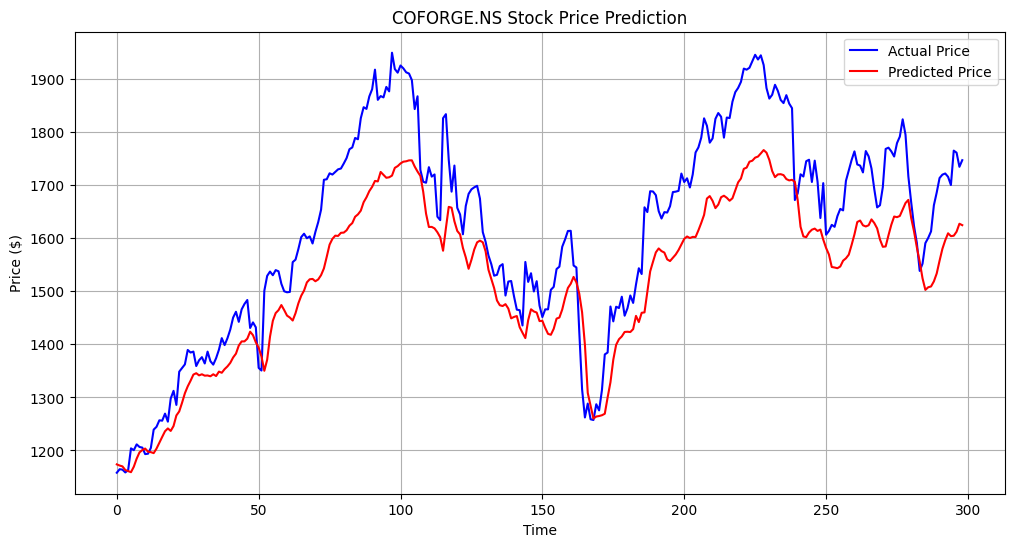

Saved the plot of COFORGE.NS to Plots/COFORGE_Prediction.png
Model saved as Models/COFORGE_LSTM.keras

✅ Saved (data + model + scaler + Hyperparams + plot + metrics) permanently for COFORGE.NS in Results/results.json


In [ ]:
# Script to run the whole process for each ticker

# Load old results if file exists
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        results = json.load(f)
else:
    results = {}

try:
    index, ticker = next(ticker_iterator)

    # --- Hyperparameter tuning ---
    best_params, best_score = run_hyperparameter_tuning(ticker=ticker, period='7y', n_trials=30)

    # --- Model training and metrics ---
    predictor = StockPredictor(best_params, ticker=ticker, period='7y')
    metrics = predictor.run_pipeline()  # {"MSE": ..., "MAPE": ..., "RMSE": ..., "R_square": ...}

    # --- Save both hyperparameters + metrics ---
    results[ticker] = {
        "Hyperparameters": best_params,
        "Metrics": metrics
    }

    # Write to disk (overwrite safely)
    with open(save_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\n✅ Saved (data + model + scaler + Hyperparams + plot + metrics) permanently for {ticker} in {save_path}")

except StopIteration:
    print("\nAll tickers processed.")

In [7]:
# After running for 2 ticker check if the .json file saves for both of the ticker or not
import json
from pprint import pprint  # makes it print nicely

import json
from pprint import pprint  # makes it print nicely

with open("Results/results.json", "r") as f:
    data = json.load(f)

pprint(data)

{'COFORGE.NS': {'Hyperparameters': {'batch_size': 32,
                                    'dropout_rate': 0.15120464555512497,
                                    'epochs': 198,
                                    'learning_rate': 0.0038546912594668884,
                                    'num_layers': 2,
                                    'sequence_length': 46,
                                    'units': 103},
                'Metrics': {'mae': 94.55607232441471,
                            'mape': 5.599414093833028,
                            'r2': 0.6880298493278172,
                            'rmse': 109.80070311497484}},
 'HCLTECH.NS': {'Hyperparameters': {'batch_size': 32,
                                    'dropout_rate': 0.1171942605576092,
                                    'epochs': 132,
                                    'learning_rate': 0.006586289317583112,
                                    'num_layers': 2,
                                    'sequence_length': 35